# Профильное задание

## Описание

Дан тренировочный датасет с текстами сообщений из мессенджера на английском языке. Для каждого из них проставлен флаг того, является ли сообщение СПАМом.

Так же дан тестовый датасет с такими же текстами сообщений, но без флага. На нем нужно будет проскорить модель и приложить результаты.

Поля датасета:
* text_type - целевая переменная, флаг СПАМ/не СПАМ
* text - текст сообщения

## Задачи:

* провести базовую аналитику по имеющимся данным,
* обучить модель по тексту сообщения определять, является ли ее содержимое СПАМом (ожидается, что будут опробованы несколько подходов, из которых аргументированно выбирается наилучший; можно использовать любую библиотеку или фреймворк),
* целевой метрикой при оценке работы модели будет ROC-AUC score,
* произвести скоринг лучшей моделью тестовых данных, а результат записать в csv-файл в виде таблицы с колонками score и text;
* выложить код на jupyter notebook и результирующий файл со скорами модели на https://github.com отдельным проектом и поделиться ссылкой в поле для ответа.

# Import libraries

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.0 MB/s eta 0:00:00


In [2]:
import nltk
import pandas as pd
import numpy as np
from collections import defaultdict

# for visualization
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

# for preprocessing
import string
import re
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

# for models
from catboost import CatBoostClassifier, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Project running on device: ", device)

Project running on device:  cpu


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# EDA

### Анализ данных

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/vk_intern_spam_or_ham/train_spam.csv')
test_df = pd.read_csv('/content/drive/MyDrive/vk_intern_spam_or_ham/test_spam.csv')

Первым делом посмотрим на наши данные, будем рассматривать только `train_df`, так как `test_df` будет использоваться для скоринга итоговой модели

In [8]:
train_df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Для более удобной работы, поменяем `text_type` на `target`, так как это целевая переменная и заменим значения `ham` и `spam` на `0` и `1` соотвественно

In [9]:
class_dict = {
    'ham': 0,
    'spam': 1
}

train_df.rename(columns={'text_type': 'target'}, inplace=True)

train_df['target'] = train_df['target'].map(class_dict)
train_df.head()

,target,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


Теперь посмотрим базовую информацию по нашим данным

In [10]:
train_df.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16278 non-null  int64 
 1   text    16278 non-null  object
dtypes: int64(1), object(1)
memory usage: 254.5+ KB


Также проверим на наличие дубликатов

In [11]:
print(f"There are {train_df.duplicated().sum()} duplicated values in the dataset")

There are 11 duplicated values in the dataset


В нашем наборе данных есть повторяющиеся данные. Скорее всего они появились из за ошибки сбора данных. Какова бы ни была причина, их следует удалить, так как это может привести к неправильным выводам, например, что некоторые наблюдения встречаются чаще, чем на самом деле, а также они оказывают негативное влияние на модель

In [12]:
train_df.drop_duplicates(inplace = True)

После того как мы убрали дубликаты, можно проверить на наличие пустых значений

In [13]:
train_df.isnull().sum()

target    0
text      0
dtype: int64

Как мы можем увидеть, в наших данных не оказалось пустых значений

In [14]:
train_df.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 16267 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16267 non-null  int64 
 1   text    16267 non-null  object
dtypes: int64(1), object(1)
memory usage: 381.3+ KB


Как и было сказано ранее, мы имеем две колонки, одна с типом текста и вторая с самим текстом. Теперь предлагаю посмотреть сбалансированы ли наши данные по типу текста.

In [15]:
count_types = train_df['target'].value_counts()
count_types

target
0    11458
1     4809
Name: count, dtype: int64

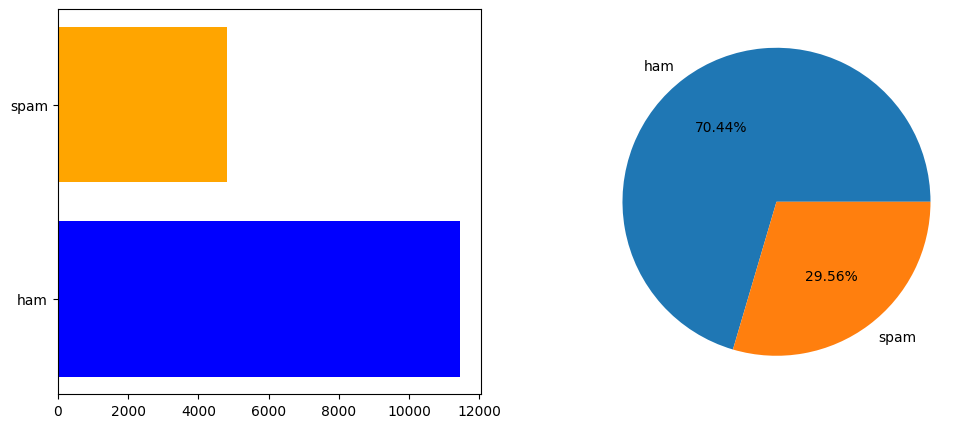

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh(['ham', 'spam'], count_types.values, color = ['blue', 'orange'])
plt.subplot(1,2,2)
plt.pie(count_types.values, labels=["ham", "spam"], autopct = '%.2f%%')
plt.show()

Как мы видим, класс spam составляет ~30%, а класс ham ~70% из общей выборки, что означает, что наши данные не сбалансированы

## Попробуем найти и добавить еще признаки

Первое, что можно попробовать, это измерить длину сообщений и посмотреть на частоту использования той или иной длины для каждого типа сообщения

In [17]:
train_df['length'] = train_df.text.apply(len)
train_df.head()

,target,text,length
0,0,make sure alex knows his birthday is over in f...,86
1,0,a resume for john lavorato thanks vince i will...,520
2,1,plzz visit my website moviesgodml to get all m...,126
3,1,urgent your mobile number has been awarded wit...,139
4,0,overview of hr associates analyst project per ...,733


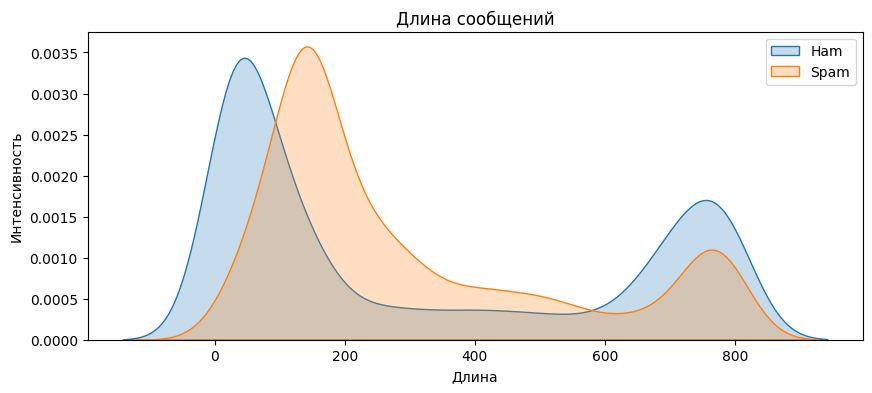

In [18]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(train_df.loc[train_df.target == 0, "length"], fill=True, label="Ham")
sns.kdeplot(train_df.loc[train_df.target == 1, "length"], fill=True, label="Spam")
ax.set(
    xlabel="Длина",
    ylabel="Интенсивность",
    title="Длина сообщений",
)
ax.legend(loc="upper right")
plt.show()

Как мы можем увидеть из графика выше, длина сообщения разных категорий имеет похожее распределение, но можно отметить, что их пики приходятся на разные длины сообщений

In [19]:
train_df.groupby('target')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,11458.0,314.293245,307.244128,1.0,41.0,140.5,686.0,800.0
1,4809.0,301.357247,235.220984,5.0,136.0,195.0,433.0,800.0


## Text preprocessing

### 1 Шаг: Удаление знаков препинания и приведение текста к нижнему регистру

Первое, что мы сделаем, это удалим все знаки препинания и заменим заглавные буквы на строчные, так как они могут создавать помехи в данных, а также помешают в следующем этапе обработки

In [20]:
text_without_punc = lambda text: ''.join(char for char in text if char not in string.punctuation)
convert_to_lowercase = lambda text: text.lower()

train_df['preprocess_text'] = train_df['text'].apply(text_without_punc)
train_df['preprocess_text'] = train_df['preprocess_text'].apply(convert_to_lowercase)

In [21]:
train_df.head()

,target,text,length,preprocess_text
0,0,make sure alex knows his birthday is over in f...,86,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...,520,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...,126,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...,139,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...,733,overview of hr associates analyst project per ...


### 2 Шаг: Токенизация

Вторым шагом, мы унифицируем и структурируем текст. Для этого мы разобьем текст на униграммы (одно слово)

In [22]:
tokenize = lambda text: re.split('\W+', text)

train_df['preprocess_text'] = train_df['preprocess_text'].apply(tokenize)

In [23]:
train_df.head()

,target,text,length,preprocess_text
0,0,make sure alex knows his birthday is over in f...,86,"[make, sure, alex, knows, his, birthday, is, o..."
1,0,a resume for john lavorato thanks vince i will...,520,"[a, resume, for, john, lavorato, thanks, vince..."
2,1,plzz visit my website moviesgodml to get all m...,126,"[plzz, visit, my, website, moviesgodml, to, ge..."
3,1,urgent your mobile number has been awarded wit...,139,"[urgent, your, mobile, number, has, been, awar..."
4,0,overview of hr associates analyst project per ...,733,"[overview, of, hr, associates, analyst, projec..."


### 3 Шаг: Удаляем Стоп-слова и применяем Лемматизацию

Третьим шагом, мы удалим стоп-слова потому что обычно отдельное употребление этих слов не вносит в текст какой-то отдельный особенный смысл. После этой операции мы применим лемматизацию, потому что она помогает сократить количество токенов в документе, так как она приводить разные уникальные формы слов к начальной, исходной форме.

In [24]:
stop_words = stopwords.words('english')

remove_stopwords = lambda text: [word for word in text if word not in stop_words]

train_df['preprocess_text'] = train_df['preprocess_text'].apply(remove_stopwords)

In [25]:
train_df.head()

,target,text,length,preprocess_text
0,0,make sure alex knows his birthday is over in f...,86,"[make, sure, alex, knows, birthday, fifteen, m..."
1,0,a resume for john lavorato thanks vince i will...,520,"[resume, john, lavorato, thanks, vince, get, m..."
2,1,plzz visit my website moviesgodml to get all m...,126,"[plzz, visit, website, moviesgodml, get, movie..."
3,1,urgent your mobile number has been awarded wit...,139,"[urgent, mobile, number, awarded, 2000, prize,..."
4,0,overview of hr associates analyst project per ...,733,"[overview, hr, associates, analyst, project, p..."


Теперь лемматизируем слова

In [26]:
wn = nltk.WordNetLemmatizer()

lemmatizer = lambda text: [wn.lemmatize(word) for word in text]

train_df['preprocess_text'] = train_df['preprocess_text'].apply(lemmatizer)

In [27]:
train_df.head()

,target,text,length,preprocess_text
0,0,make sure alex knows his birthday is over in f...,86,"[make, sure, alex, know, birthday, fifteen, mi..."
1,0,a resume for john lavorato thanks vince i will...,520,"[resume, john, lavorato, thanks, vince, get, m..."
2,1,plzz visit my website moviesgodml to get all m...,126,"[plzz, visit, website, moviesgodml, get, movie..."
3,1,urgent your mobile number has been awarded wit...,139,"[urgent, mobile, number, awarded, 2000, prize,..."
4,0,overview of hr associates analyst project per ...,733,"[overview, hr, associate, analyst, project, pe..."


Для дальнейшего удобства объединим все преобразования в одну функцию

In [28]:
def clean_text(text):
    wn_lemma = nltk.WordNetLemmatizer()
    stop_words = stopwords.words('english')

    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn_lemma.lemmatize(word) for word in tokens if word not in stop_words]

    return text

## Формируем тренировочную и валидационную выборку

Первым делом разделим наши данные на две выборки

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['target'],
                                                                    random_state=42,
                                                                    test_size=0.2,
                                                                    stratify=train_df['target'])

После того, как мы разделили наш датасет на тестовую и тренировочную выборку, нам надо векторизовать текст, то есть описать его с помощью чисел. Для этого мы будем использовать довольно простой метод Bag of Words (подсчитывает как часто встречается каждое слово в тексте) в связке с TF-IDF (вычисляет важность каждого слова в документе относительно количества его употреблений в данном документе и во всей коллекции текстов), но так как мы предварительно обработали данные, то он должен достаточно хорошо сработать. Данные методы уже реализованы в библиотеке sklearn в виде функций CountVectorizer и TfidfTransformer, но также мы можем использовать TfidfVectorizer, который включает в себя обе эти функции

In [30]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

Теперь мы имеем готовый тренировочный и тестовый датасет и можем перейти к этапу построения моделей

# Делаем Модели

### Логистическая регрессия

Первой моделью мы возьмем логистическую регрессию, так как она очень хорошо ложится на нашу задачу (бинарной классификации) и достаточно проста, чтобы стать baseline моделью.  

In [32]:
lr = LogisticRegression()

In [33]:
lr.fit(tfidf_train, y_train)

LogisticRegression()

In [34]:
predicted = lr.predict(tfidf_test)

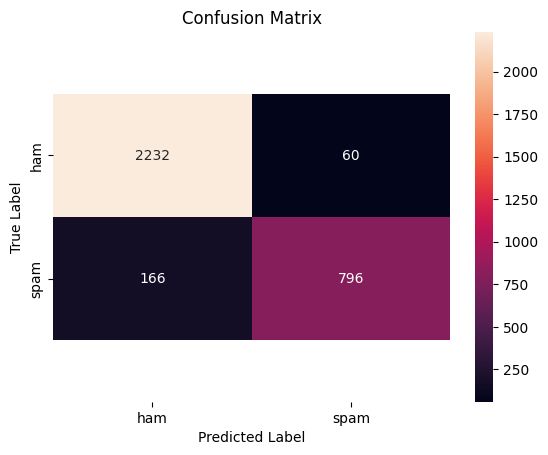

In [35]:
cm = confusion_matrix(y_test, predicted)

class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [36]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2292
           1       0.93      0.83      0.88       962

    accuracy                           0.93      3254
   macro avg       0.93      0.90      0.91      3254
weighted avg       0.93      0.93      0.93      3254



In [37]:
roc_auc_score(y_test, lr.predict_proba(tfidf_test)[:, 1])

0.9782825011882603

### Градиентный бустинг

Второй моделью будет градиентный бустинг, хоть он и не так хорош при работе с текстами, но стоит оценить его работоспособность на нашем датасете. В качестве градиентного бустинга мы выберем реализацию catboost, так как это модель хорошо работает с категориальными признаками и текстами, так как имеет собственные функции для предобработки текста

In [38]:
X_train = X_train.drop(['target', 'preprocess_text'], axis=1)
X_test = X_test.drop(['target', 'preprocess_text'], axis=1)

In [39]:
train_pool = Pool(
    X_train,
    y_train,
    text_features=['text'],
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test,
    y_test,
    text_features=['text'],
    feature_names=list(X_test)
)

In [42]:
catClassifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    eval_metric='AUC',
    # task_type='GPU',
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=50
)

In [43]:
catClassifier.fit(train_pool, eval_set=valid_pool)

0:	test: 0.9326175	best: 0.9326175 (0)	total: 1.11s	remaining: 18m 31s
50:	test: 0.9808488	best: 0.9811384 (45)	total: 23.9s	remaining: 7m 24s
100:	test: 0.9859921	best: 0.9860094 (99)	total: 41.3s	remaining: 6m 7s
150:	test: 0.9870189	best: 0.9870266 (149)	total: 58.5s	remaining: 5m 28s
200:	test: 0.9871421	best: 0.9871917 (189)	total: 1m 15s	remaining: 4m 59s
250:	test: 0.9875618	best: 0.9875759 (248)	total: 1m 32s	remaining: 4m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9875758763
bestIteration = 248

Shrink model to first 249 iterations.


In [44]:
predicted = catClassifier.predict(X_test)

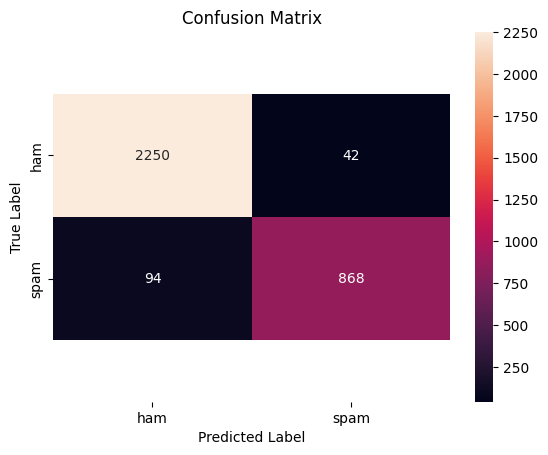

In [45]:
cm = confusion_matrix(y_test, predicted)

class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [46]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2292
           1       0.95      0.90      0.93       962

    accuracy                           0.96      3254
   macro avg       0.96      0.94      0.95      3254
weighted avg       0.96      0.96      0.96      3254



In [47]:
roc_auc_score(y_test, catClassifier.predict_proba(X_test)[:, 1])

0.9875758763193317

### Simple RNN

Третьей моделью, которую мы применим для нашей задачи, будет РНС, так как она хороша при анализе контекста и общей связи слов в тексте. Она достаточно хорошо извлекает признаки, что должно повысить точность

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train['text'], y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['text'], y_test))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=[keras.metrics.AUC()])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
204/204 [==============================] - 48s 145ms/step - loss: 0.6124 - auc: 0.5755 - val_loss: 0.4538 - val_auc: 0.8872
Epoch 2/10
204/204 [==============================] - 11s 55ms/step - loss: 0.3275 - auc: 0.9286 - val_loss: 0.2403 - val_auc: 0.9620
Epoch 3/10
204/204 [==============================] - 9s 41ms/step - loss: 0.2070 - auc: 0.9679 - val_loss: 0.1848 - val_auc: 0.9741
Epoch 4/10
204/204 [==============================] - 7s 36ms/step - loss: 0.1654 - auc: 0.9786 - val_loss: 0.1665 - val_auc: 0.9766
Epoch 5/10
204/204 [==============================] - 8s 37ms/step - loss: 0.1446 - auc: 0.9831 - val_loss: 0.1542 - val_auc: 0.9797
Epoch 6/10
204/204 [==============================] - 6s 28ms/step - loss: 0.1336 - auc: 0.9851 - val_loss: 0.1563 - val_auc: 0.9817
Epoch 7/10
204/204 [==============================] - 6s 27ms/step - loss: 0.1238 - auc: 0.9871 - val_loss: 0.1508 - val_auc: 0.9802
Epoch 8/10
204/204 [==============================] - 6s 30ms/step

In [ ]:
prediction_proba = model.predict(X_test['text'])

102/102 [==============================] - 7s 17ms/step


In [ ]:
prediction = np.concatenate(prediction_proba)

prediction_binary = np.where(prediction > 0.5, 1, 0)

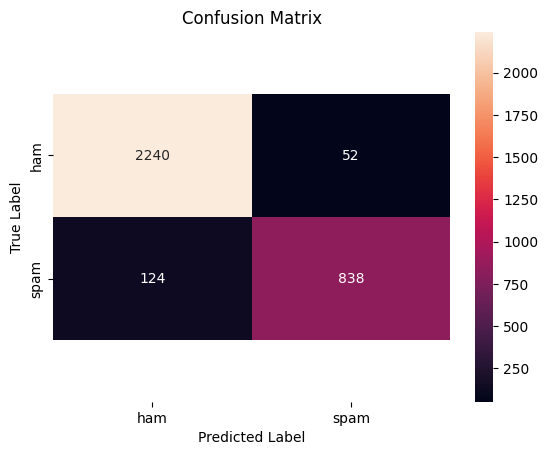

In [ ]:
cm = confusion_matrix(y_test, prediction_binary)

class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(classification_report(y_test, prediction_binary))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2292
           1       0.94      0.87      0.90       962

    accuracy                           0.95      3254
   macro avg       0.94      0.92      0.93      3254
weighted avg       0.95      0.95      0.95      3254



In [ ]:
roc_auc_score(y_test, prediction_proba)

0.979098863261167

### Bert

Четвертой моделью, которую мы будем использовать, будет BERT, так как он очень хорошо справляется с обработкой текста и показывает хорошие результаты в решении различных задач обработки естественного языка, том числе и классификации текста.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

EPOCHS=5
MAX_LEN=512
BATCH_SIZE=16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, text, tokenizer, max_len, target=None, test_train=True):
        if test_train:
            self.text = text
            self.target = target
            self.tokenizer = tokenizer
            self.max_len = max_len
            self.test_train = test_train
        else:
            self.text = text
            self.tokenizer = tokenizer
            self.max_len = max_len
            self.test_train = test_train

    def __len__(self):
        return len(self.text)

    def __getitem__(self, i):
        if self.test_train:
            text = str(self.text[i])
            target = self.target[i]

            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                truncation=True,
                return_token_type_ids=False,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )

            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'target': torch.tensor(target, dtype=torch.long)
            }
        else:
            text = str(self.text[i])

            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                truncation=True,
                return_token_type_ids=False,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )

            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
            }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size, test_train=True):
    if test_train:
        ds = SpamDataset(
            target=df['target'].to_numpy(),
            text=df['text'].to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len,
            test_train=test_train
        )
    else:
        ds = SpamDataset(
            text=df['text'].to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len,
            test_train=test_train
        )

    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [ ]:
bert_df = train_df[['text', 'target']]

In [ ]:
df_train, df_test = train_test_split(
    bert_df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

((13013, 2), (1627, 2), (1627, 2))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SpamClassifier(n_classes=2)
model = model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    batch_bar = tqdm(total=len(data_loader), dynamic_ncols=True,
                 leave=False, position=0, desc="Train")

    for i, d in enumerate(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['target'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        batch_bar.set_postfix(
            loss = f"{sum(losses)/(i+1):.4f}"
        )
        batch_bar.update()

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    batch_bar = tqdm(total=len(data_loader), dynamic_ncols=True,
                 leave=False, position=0, desc="Validation")

    with torch.no_grad():
        for i, d in enumerate(data_loader):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            batch_bar.set_postfix(
            loss = f"{sum(losses)/(i+1):.4f}"
            )
            batch_bar.update()

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Для того, чтобы каждый раз не обучать модель, мы предварительно сохранили её.

In [ ]:
model = SpamClassifier(n_classes=2)

model.load_state_dict(torch.load('/content/drive/MyDrive/vk_intern_spam_or_ham/best_model_state_3.bin',
                                 map_location=torch.device('cpu')))
model = model.to(device)

model.eval()

SpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.970497848801475

In [ ]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    texts = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            text = d['text']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            target = d['target'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            texts.extend(text)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(target)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, predictions_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

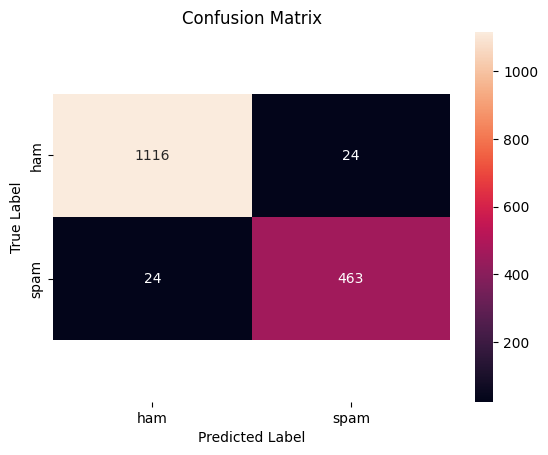

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1140
           1       0.95      0.95      0.95       487

    accuracy                           0.97      1627
   macro avg       0.96      0.96      0.96      1627
weighted avg       0.97      0.97      0.97      1627



In [ ]:
roc_auc_score(y_test, y_pred_probs[:, 1])

0.9935498396916316

# Оценивание Моделей

Так как мы будем оценивать модели по ROC_AUC, то составим таблицу для наглядности

| Метрики | Логистическая регрессия | Градиентный бустинг | RNN | BERT |
|:------------:|:-------------:|:------------:|:------------:|:------------:|
| ROC_AUC    |    0.978    |    0.987   |   0.979    |    0.993   |


Как мы видим из таблицы выше, у нас модель BERT является наилучшей среди дркгих моделей, но также стоит учитывать ресурсы и время потребляемые данной моделью, но у нас в условиях нет ограничений по ресурсам, поэтому итоговой моделью будет BERT.

Примечание: Если нам важно легковесность и быстрота модели, то выбор пал бы на CatBoost модель

# Формирование итогового решения

In [ ]:
model = SpamClassifier(n_classes=2)

model.load_state_dict(torch.load('/content/drive/MyDrive/vk_intern_spam_or_ham/best_model_state_3.bin',
                                 map_location=torch.device('cpu')))
model = model.to(device)

model.eval()

SpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
sub_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, test_train=False)

In [ ]:
def get_predictions(
    model, data_loader
):
    model = model.eval().to(device)

    predictions = []

    with torch.no_grad():
        for d in data_loader:
            text = d['text']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)

    predictions = torch.stack(predictions).cpu()

    return predictions

In [ ]:
y_pred = get_predictions(
  model,
  sub_data_loader
)

In [ ]:
submission = pd.DataFrame({"text": test_df['text'],
                           "score": y_pred})

In [ ]:
submission.to_csv("submission.csv", index=False)